# <font color = 'gold'> Data Science Project </font>
# <font color = 'Teal'> Business problem </font>
We need build a machine that is able to separete users by their electric power consumption and help the company to understand their behavior.
By doing this the company will be the right knowledge to approach each segment in a special way.

### Data source
https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score

In [55]:
df = pd.read_csv('data/household_power_consumption.txt', delimiter = ';', low_memory = False)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.00
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.00
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.00
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.00
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.00


**<font color = 'grey'> Attribute Information: </font>**

1. date: Date in format dd/mm/yyyy
2. time: time in format hh:mm:ss
3. global_active_power: household global minute-averaged active power (in kilowatt)
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

# <font color = 'orange'> Data Exploration </font>

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [57]:
# checking null values
df.isnull().sum() / df.shape[0] * 100

Date                    0.00
Time                    0.00
Global_active_power     0.00
Global_reactive_power   0.00
Voltage                 0.00
Global_intensity        0.00
Sub_metering_1          0.00
Sub_metering_2          0.00
Sub_metering_3          1.25
dtype: float64

As we can see, all missing data represents only 1.25% of all data in Sub_metering_3 variable.
We can presume that removing the rows with the missing data will not affect out comprehension of the data and the performance of out model.

In [58]:
missing_values = df.Sub_metering_3.isnull()
df = df.loc[~missing_values]
df.isnull().sum()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [59]:
cols = 'Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2'.split(',')

for c in cols:
    df[c] = pd.to_numeric(df[c])

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049280 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 156.3+ MB


In [61]:
pd.options.display.float_format = '{:,.2f}'.format

df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,"2,049,280.00","2,049,280.00","2,049,280.00","2,049,280.00","2,049,280.00","2,049,280.00","2,049,280.00"
mean,1.09,0.12,240.84,4.63,1.12,1.30,6.46
std,1.06,0.11,3.24,4.44,6.15,5.82,8.44
min,0.08,0.00,223.20,0.20,0.00,0.00,0.00
25%,0.31,0.05,238.99,1.40,0.00,0.00,0.00
50%,0.60,0.10,241.01,2.60,0.00,0.00,1.00
75%,1.53,0.19,242.89,6.40,0.00,1.00,17.00
max,11.12,1.39,254.15,48.40,88.00,80.00,31.00


In [35]:
df.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.00,0.25,-0.40,1.00,0.48,0.43,0.64
Global_reactive_power,0.25,1.00,-0.11,0.27,0.12,0.14,0.09
Voltage,-0.40,-0.11,1.00,-0.41,-0.20,-0.17,-0.27
Global_intensity,1.00,0.27,-0.41,1.00,0.49,0.44,0.63
Sub_metering_1,0.48,0.12,-0.20,0.49,1.00,0.05,0.10
Sub_metering_2,0.43,0.14,-0.17,0.44,0.05,1.00,0.08
Sub_metering_3,0.64,0.09,-0.27,0.63,0.10,0.08,1.00


# <font color = 'orange'> Dist. Variables </font>

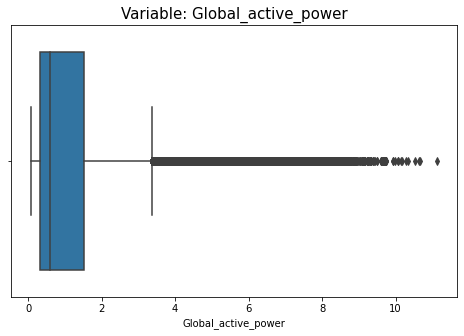

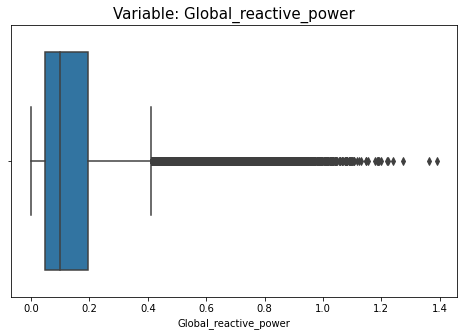

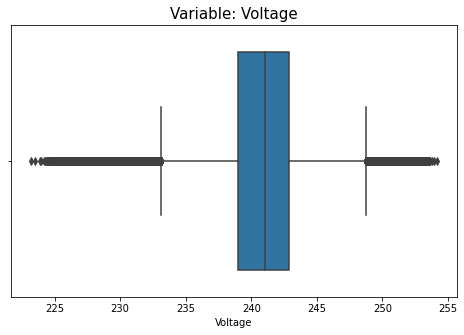

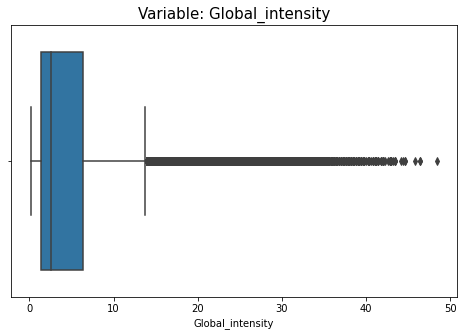

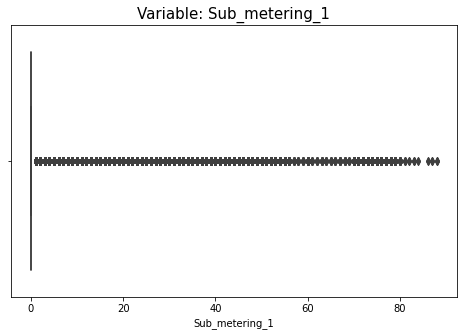

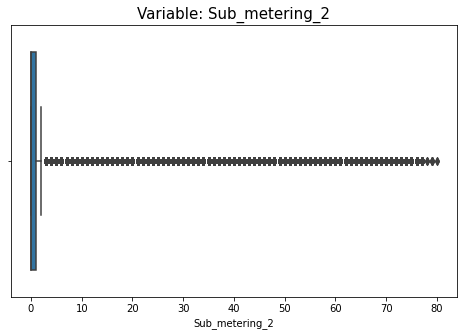

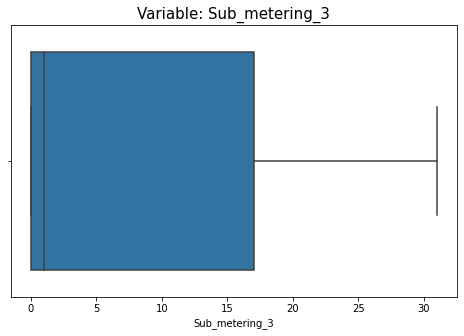

In [36]:
cols = 'Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3'.split(',')

for col in cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data = df,
                x = col)
    title = 'Variable: ' + col
    plt.title(title, fontsize = 15)
    plt.show()

As we can see, the distribuition of the last three variables is not even close to be simetric. Maybe it would</br> be better to remove theses variables from our model. 

But we can test both versions

# <font color = 'orange'> Kmeans - V1 </font>

Using all variables

## <font color = 'gold'> Pre Processing </font>

In [62]:
df = df.drop(columns=['Date', 'Time'])

In [63]:
df_sample, _ = train_test_split(df, train_size = 0.02, random_state=42)
df_sample.shape

(40985, 7)

## <font color = 'gold'> KMeans - Building the Model </font>

In [64]:
k_range = range(1,12)
k_range

range(1, 12)

In [65]:
k_means_var = [KMeans(n_clusters = k).fit(df_sample) for k in k_range]

/Users/matheuscunha/ambientes-virtuais/data-science/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/matheuscunha/ambientes-virtuais/data-science/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/matheuscunha/ambientes-virtuais/data-science/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/matheuscunha/ambientes-virtuais/data-science/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

In [66]:
inertias = [model.inertia_ for model in k_means_var]

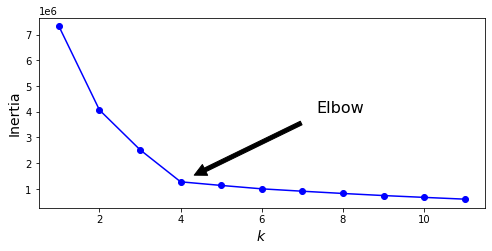

In [67]:
elbow_curve = 4

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 12), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(elbow_curve, inertias[elbow_curve - 1]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

In [68]:
# testing with 8 clusters

v1_model_8 = KMeans(n_clusters = 8)
v1_model_8.fit(df_sample)

# Silhouette Score
labels = v1_model_8.labels_
silhouette_score(df_sample, labels, metric = 'euclidean')

/Users/matheuscunha/ambientes-virtuais/data-science/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.37419312383509484

In [69]:
# testing with 4 clusters

v1_model_4 = KMeans(n_clusters = 4)
v1_model_4.fit(df_sample)

# Silhouette Score
labels = v1_model_4.labels_
silhouette_score(df_sample, labels, metric = 'euclidean')

/Users/matheuscunha/ambientes-virtuais/data-science/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.7172424719380804

In [71]:
# testing with 5 clusters

v1_model_5 = KMeans(n_clusters = 5)
v1_model_5.fit(df_sample)

# Silhouette Score
labels = v1_model_5.labels_
silhouette_score(df_sample, labels, metric = 'euclidean')

/Users/matheuscunha/ambientes-virtuais/data-science/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.4652912882407881

In [72]:
# testing with 3 clusters

v1_model_3 = KMeans(n_clusters = 3)
v1_model_3.fit(df_sample)

# Silhouette Score
labels = v1_model_3.labels_
silhouette_score(df_sample, labels, metric = 'euclidean')

/Users/matheuscunha/ambientes-virtuais/data-science/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.6816426802478478

# <font color = 'orange'> Kmeans - V2 </font>

Removing Sub_metering_1, Sub_metering_2 and Sub_metering_3

In [78]:
df_v2 = df.drop(columns='Sub_metering_1,Sub_metering_2,Sub_metering_3'.split(','))

In [82]:
clusters = range(1, 12)

k_means_var_v2 = [KMeans(n_clusters= k).fit(df_v2) for k in clusters]

/Users/matheuscunha/ambientes-virtuais/data-science/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/matheuscunha/ambientes-virtuais/data-science/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/matheuscunha/ambientes-virtuais/data-science/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/matheuscunha/ambientes-virtuais/data-science/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

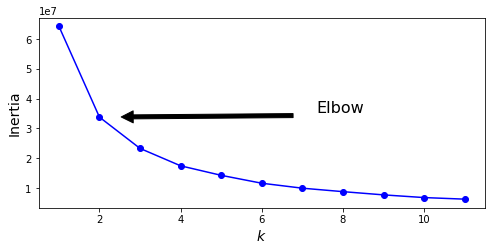

In [85]:
inertias = [model.inertia_ for model in k_means_var_v2]


elbow_curve = 2

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 12), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(elbow_curve, inertias[elbow_curve - 1]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

In [87]:
# Testing with 8 clusters
v2_model_8 = KMeans(n_clusters = 8)
v2_model_8.fit(df_v2)

# Silhouette Score
labels = v2_model_8.labels_
silhouette_score(df_v2, labels, metric = 'euclidean')

/Users/matheuscunha/ambientes-virtuais/data-science/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Testing with 4 clusters

v2_model_4 = KMeans(n_clusters = 4)
v2_model_4.fit(df_v2)

# Silhouette Score
labels = v2_model_4.labels_
silhouette_score(df_v2, labels, metric = 'euclidean')

In [ ]:
# Testing with 2 clusters

v2_model_2 = KMeans(n_clusters = 2)
v2_model_2.fit(df_v2)

# Silhouette Score
labels = v2_model_2.labels_
silhouette_score(df_v2, labels, metric = 'euclidean')